In [25]:
!pip install kagglehub

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, accuracy_score



In [26]:
path = kagglehub.dataset_download("krantiswalke/bankfullcsv")
print("Dataset downloaded at:", path)

Using Colab cache for faster access to the 'bankfullcsv' dataset.
Dataset downloaded at: /kaggle/input/bankfullcsv


In [27]:
# Find CSV file
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)

# Load dataset
df = pd.read_csv(csv_path)
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [28]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [29]:
# Rename target column
df.rename(columns={'Target': 'y'}, inplace=True)

# Replace 'unknown' with NaN
df.replace("unknown", np.nan, inplace=True)

# Fill missing categorical values
for col in df.select_dtypes(include='object'):
    df[col].fillna(df[col].mode()[0], inplace=True)

df.isnull().sum()


/tmp/ipython-input-652717681.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [30]:
X = df.drop('y', axis=1)
y = df['y']


In [31]:
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [33]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    random_state=42
)

model.fit(X_train_transformed, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

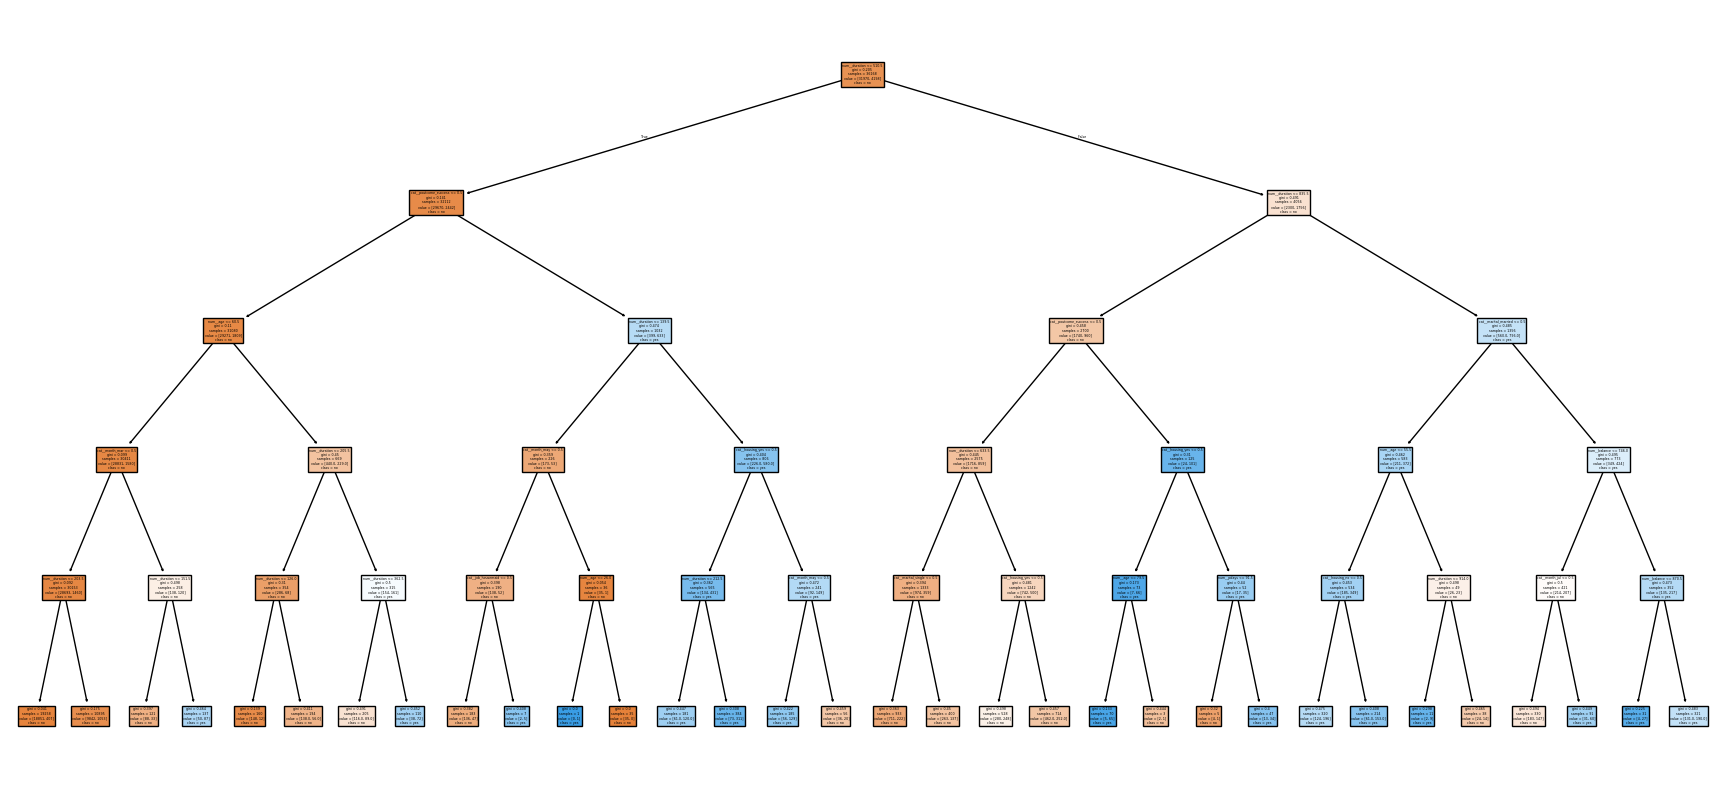

In [34]:
plt.figure(figsize=(22, 10))
plot_tree(
    model,
    feature_names=preprocessor.get_feature_names_out(),
    class_names=['no', 'yes'],
    filled=True
)
plt.show()


In [35]:
y_pred = model.predict(X_test_transformed)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Training Accuracy:", accuracy_score(y_train, model.predict(X_train_transformed)))
print("Testing Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

          no       0.91      0.98      0.94      7952
         yes       0.65      0.33      0.44      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.88      9043

Training Accuracy: 0.9062707365627074
Testing Accuracy: 0.8977109366360722


In [36]:
rules = export_text(
    model,
    feature_names=list(preprocessor.get_feature_names_out())
)

print(rules)


|--- num__duration <= 510.50
|   |--- cat__poutcome_success <= 0.50
|   |   |--- num__age <= 60.50
|   |   |   |--- cat__month_mar <= 0.50
|   |   |   |   |--- num__duration <= 203.50
|   |   |   |   |   |--- class: no
|   |   |   |   |--- num__duration >  203.50
|   |   |   |   |   |--- class: no
|   |   |   |--- cat__month_mar >  0.50
|   |   |   |   |--- num__duration <= 151.50
|   |   |   |   |   |--- class: no
|   |   |   |   |--- num__duration >  151.50
|   |   |   |   |   |--- class: yes
|   |   |--- num__age >  60.50
|   |   |   |--- num__duration <= 205.50
|   |   |   |   |--- num__duration <= 126.00
|   |   |   |   |   |--- class: no
|   |   |   |   |--- num__duration >  126.00
|   |   |   |   |   |--- class: no
|   |   |   |--- num__duration >  205.50
|   |   |   |   |--- num__duration <= 362.50
|   |   |   |   |   |--- class: no
|   |   |   |   |--- num__duration >  362.50
|   |   |   |   |   |--- class: yes
|   |--- cat__poutcome_success >  0.50
|   |   |--- num__duration 